# Training Pipeline
* Create and return Feature View and its dataset
* Define, tune and train the regression model
* Evaluate model
* Push model to Hopsworks

In [1]:
import os
import joblib
import pandas as pd
import hopsworks
from xgboost import XGBRegressor
from xgboost import plot_importance
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import numpy as np

import sys
sys.path.append('..')  # Add the parent directory (project root) to the Python path
from config import *

# Disable annoying warnings
import warnings
warnings.filterwarnings("ignore")

# Set path to save model and plots
if os.path.isdir(MODEL_PATH) == False:
    os.mkdir(MODEL_PATH)

# 1) Create and Return Feature View in Hopsworks

In [2]:
# Login to Hopsworks
project = hopsworks.login()

# Retrieve Feature Store
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/178324
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# Retrieve Feature Group
historical_weather_fg = fs.get_or_create_feature_group(
    name=FG_HISTORG_NAME,
    version=FG_HISTORY_V,
)

# Query: transform feature group into feature view. no feature groups to join
query = historical_weather_fg.select_all()

# Create Feature View in Hopsworks if first time, and return it
feature_view = fs.get_or_create_feature_view(
    name=FEATURE_VIEW_NAME,
    version=FEATURE_VIEW_V,
    query=query
)

# 2) Training Dataset Retrieval and Manipulation

### 2a) Create dataset in Hopsworks and download it

In [4]:
# Create a csv dataset from Hopsworks feature view
td_version, td_job = feature_view.create_training_data(
    description = 'Weather Code dataset',
    data_format = 'csv',
    write_options = {'wait_for_job': True}
)

Training dataset job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/178324/jobs/named/weather_fv_1_create_fv_td_16112023134100/executions


In [5]:
# Get the previously computed dataset
X, _ = feature_view.get_training_data(
    training_dataset_version=td_version
)

print('Dataset contains', X.shape[0], 'entries')

Dataset contains 217 entries


### 2b) Split features from labels

In [6]:
# Select only model features
X = X.drop(columns=['weather_code_desc', 'weather_code_desc_short', 'weather_code_wmo', 'date'])

# Get labels of the test set
y = X.pop('weather_code')

# 3) Model hyperameter tuning and training

In [30]:
# Create model
xgb_model_untuned = XGBRegressor(objective='reg:squarederror') # Square error is the most common loss function for regression prediction problems

# Define the hyperparameter distributions for the random search
param_dist = {
    'learning_rate': LEARNING_RATE_RANGE,
    'n_estimators': N_ESTIMATORS_RANGE,
    'max_depth': MAX_DEPTH_RANGE,
    'subsample': SUBSAMPLE_RANGE,
    'colsample_bytree': COLSAMPLE_BYTREE_RANGE,
}

# Perform random search with Cross-Validation
random_search = RandomizedSearchCV(estimator=xgb_model_untuned,
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error',
                                   cv=N_FOLD_CV,
                                   random_state=42)

# fit data
random_search.fit(X, y)

# Get best parameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Select the model with the best parameters
xgb_model = random_search.best_estimator_

Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


# 4) Model validation

### 4a) k-fold Cross-Validation

In [31]:
# Leave-One-Out Cross-Validation (LOOCV) would take too long, so let's use folds instead
kf = KFold(n_splits=N_FOLD_CV, shuffle=True, random_state=42)

# Initialize a list to store scores for each fold
r2_scores = []
rmse_scores = []
mse_scores = []
f1_scores = []

# For each fold calculate the metrics
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    xgb_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = xgb_model.predict(X_test)

    # R-squared
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

    # MSE
    mse = mean_squared_error(y_test, y_pred, squared=False)
    mse_scores.append(mse)

    # RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=True)
    rmse_scores.append(rmse)

    # Round predicted value to closest weather code as a classification
    y_pred_classified = np.round(y_pred).astype(int)

    # Weighted-averaged F1 score
    f1 = f1_score(y_test, y_pred_classified, average='weighted')
    f1_scores.append(f1)

# Calculate means and standard deviations of metrics
r2_mean = np.mean(r2_scores)
r2_sd = np.std(r2_scores)

mse_mean = np.mean(mse_scores)
mse_sd = np.std(mse_scores)

rmse_mean = np.mean(rmse_scores)
rmse_sd = np.std(rmse_scores)

f1_mean = np.mean(f1_scores)
f1_sd = np.std(f1_scores)

print("Mean R2: {:.2f}".format(r2_mean))
print("Standard Deviation of R2: {:.2f}".format(r2_sd))

print("Mean MSE: {:.2f}".format(mse_mean))
print("Standard Deviation of MSE: {:.2f}".format(mse_sd))

print("Mean RMSE: {:.2f}".format(rmse_mean))
print("Standard Deviation of RMSE: {:.2f}".format(rmse_sd))

print("Mean F1: {:.2f}".format(f1_mean))
print("Standard Deviation of F1: {:.2f}".format(f1_sd))

Mean R2: 0.86
Standard Deviation of R2: 0.05
Mean MSE: 0.54
Standard Deviation of MSE: 0.13
Mean RMSE: 0.31
Standard Deviation of RMSE: 0.15
Mean F1: 0.85
Standard Deviation of F1: 0.08


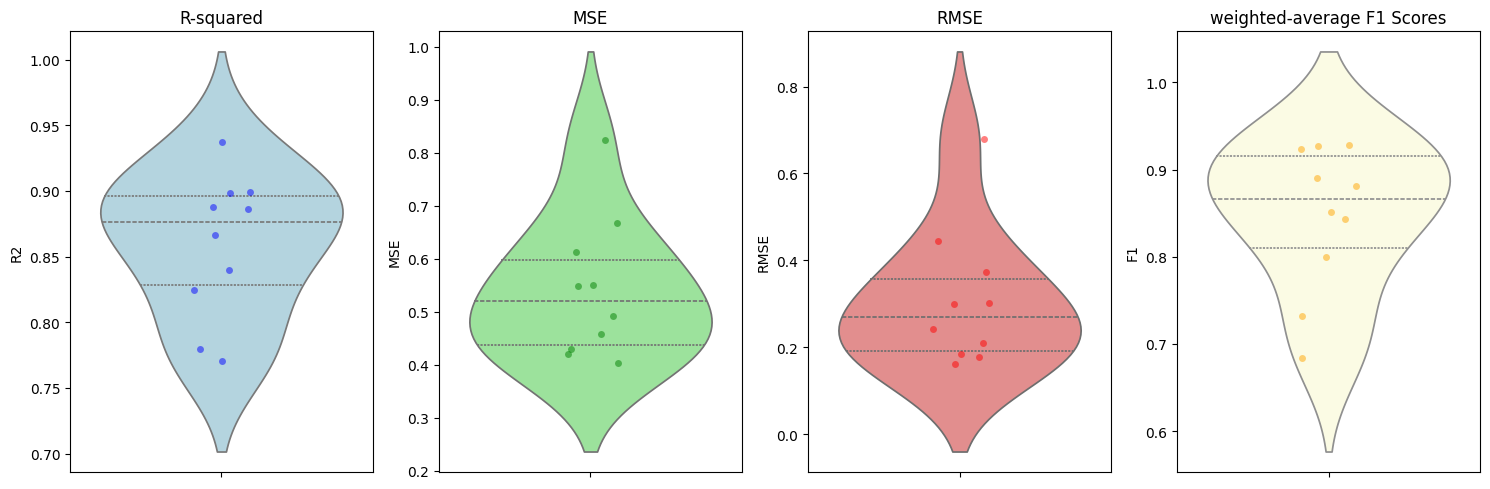

In [42]:
# Visualize previous scores

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'R2': r2_scores,
    'MSE': mse_scores,
    'RMSE': rmse_scores,
    'F1': f1_scores
})

# Set up the matplotlib figure
plt.figure(figsize=(15, 5))

# Plot vertical R-squared scores
plt.subplot(1, 4, 1)
sns.violinplot(y='R2', data=results_df, inner="quartile", color='lightblue')
sns.stripplot(y='R2', data=results_df, color='blue', alpha=0.5)
plt.title('R-squared')

# Plot vertical MSE scores
plt.subplot(1, 4, 2)
sns.violinplot(y='MSE', data=results_df, inner="quartile", color='lightgreen')
sns.stripplot(y='MSE', data=results_df, color='green', alpha=0.5)
plt.title('MSE')

# Plot vertical RMSE scores
plt.subplot(1, 4, 3)
sns.violinplot(y='RMSE', data=results_df, inner="quartile", color='lightcoral')
sns.stripplot(y='RMSE', data=results_df, color='red', alpha=0.5)
plt.title('RMSE')

# Plot vertical F1 scores
plt.subplot(1, 4, 4)
sns.violinplot(y='F1', data=results_df, inner="quartile", color='lightyellow')
sns.stripplot(y='F1', data=results_df, color='orange', alpha=0.5)
plt.title('weighted-average F1 Scores')

plt.savefig(MODEL_PATH + "/plot_scores.png")

plt.tight_layout()
plt.show()

### 4b) F1 score analysis

In [33]:
# Le'ts take a random split 80% training, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training set contains {X_train.shape[0]} samples, '
      f'while the test set contains {X_test.shape[0]}.')

# Predict over test set
y_pred = xgb_model.predict(X_test)

y_pred_classified = np.round(y_pred).astype(int)

# Add again the labels of weather codes
df_codes_mapping = pd.read_csv("../resources/weather_code_mapping.csv")
target_names = df_codes_mapping['weather_code_desc']
combined_indices = np.concatenate([y_pred_classified, y_test])
selected_rows = df_codes_mapping[df_codes_mapping['weather_code'].isin(combined_indices)]
filtered_target_names = selected_rows['weather_code_desc']

# Print full F1 report
f1_report = classification_report(y_test, y_pred_classified)
print(f1_report)

Training set contains 173 samples, while the test set contains 44.
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        12
           6       1.00      1.00      1.00         8

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



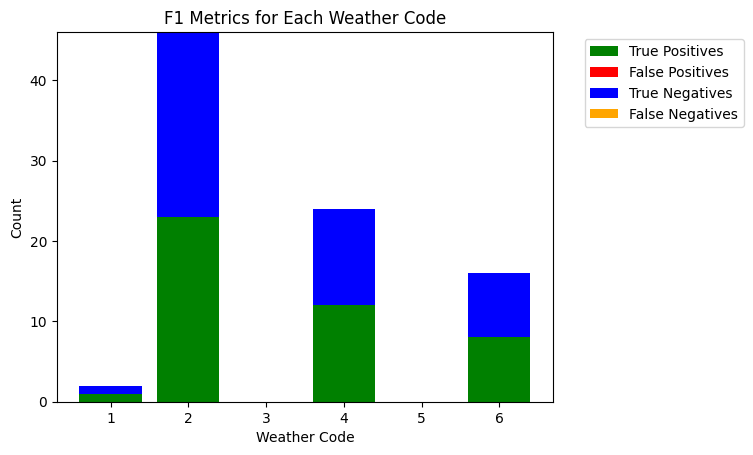

In [34]:
# Plot F1 report
report = classification_report(y_test, y_pred_classified, output_dict=True)

# Extract the relevant metrics for each class
classes = [int(c) for c in report.keys() if c.isdigit()]  # Extract numeric classes
tp = [report[str(c)]['precision'] * report[str(c)]['support'] for c in classes]
fp = [(1 - report[str(c)]['precision']) * report[str(c)]['support'] for c in classes]
tn = [report[str(c)]['recall'] * report[str(c)]['support'] for c in classes]
fn = [(1 - report[str(c)]['recall']) * report[str(c)]['support'] for c in classes]

# Create a stacked bar plot
fig, ax = plt.subplots()
ax.bar(classes, tp, label='True Positives', color='green')
ax.bar(classes, fp, bottom=tp, label='False Positives', color='red')
ax.bar(classes, tn, bottom=np.array(tp) + np.array(fp), label='True Negatives', color='blue')
ax.bar(classes, fn, bottom=np.array(tp) + np.array(fp) + np.array(tn), label='False Negatives', color='orange')

# Add labels and title
plt.xlabel('Weather Code')
plt.ylabel('Count')
plt.title('F1 Metrics for Each Weather Code')

# Move the legend outside the plot using bbox_to_anchor
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig(MODEL_PATH + "/plot_f1.png")

# Show the plot
plt.show()

plt_f1 = plt

### 4c) Distribution overview

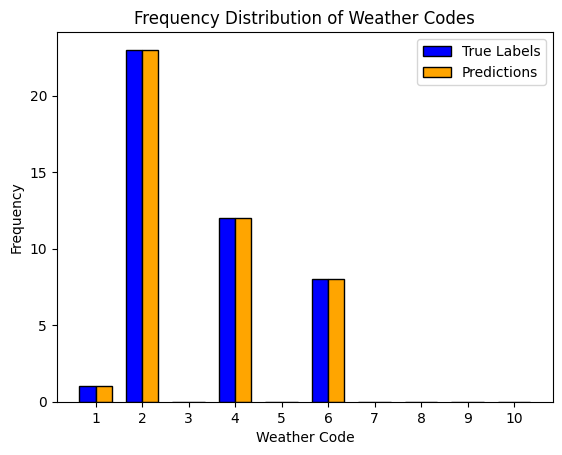

In [35]:
# Set the width of the bars
bar_width = 0.35

# Create an array for the x-axis positions
indices = np.arange(1, 11)

# Create bar plots for true labels and rounded predictions side by side
plt.bar(indices - bar_width/2, np.histogram(y_test, bins=np.arange(1, 12) - 0.5)[0], bar_width, label='True Labels', color='blue', edgecolor='black')
plt.bar(indices + bar_width/2, np.histogram(y_pred_classified, bins=np.arange(1, 12) - 0.5)[0], bar_width, label='Predictions', color='orange', edgecolor='black')

# Add labels and title
plt.xlabel('Weather Code')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Weather Codes')
plt.xticks(indices)
plt.legend()

# Show the plot
plt.show()

### 4d) Residuals

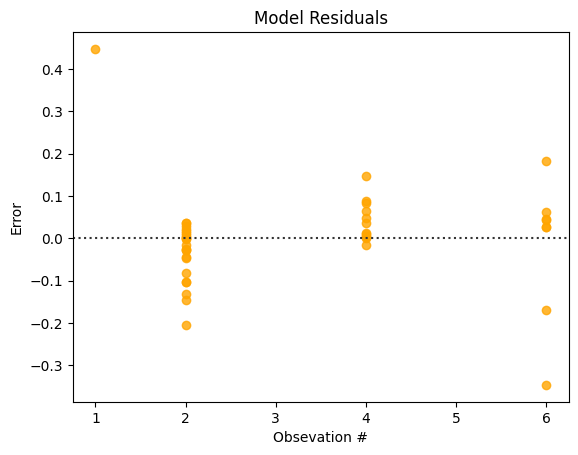

In [36]:
# Differences between the observed (actual) values and the predicted values
# Ideally, the residuals should be randomly distributed around zero, indicating that the model's predictions are unbiased
# On the x axis I see the different weather codes (difficult to inspect here, but the goal is the distribution)

df_ = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred
})
residplot = sns.residplot(data=df_, x="y_true", y="y_pred", color='orange')
plt.title('Model Residuals')
plt.xlabel('Obsevation #')
plt.ylabel('Error')

plt.show()
fig = residplot.get_figure()
fig.show()

# Save residuals plot
fig.savefig(MODEL_PATH + "/plot_residuals.png")

### 4e) Feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

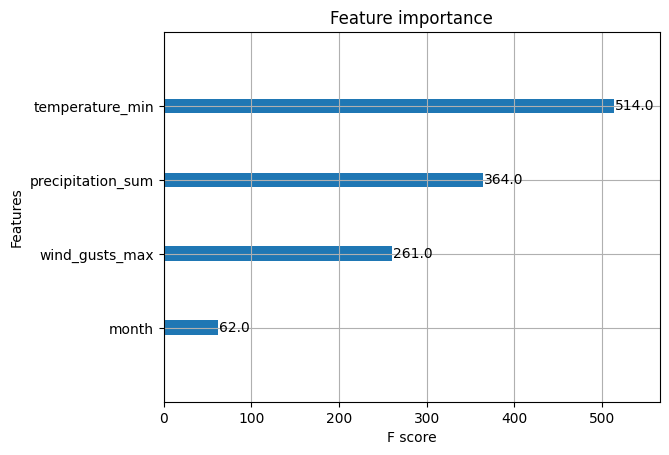

In [37]:
# Scores for each feature based on how frequently they are used in the model during the training process,
# and how much they contribute to reducing the loss function

plot_importance(xgb_model)

## 4f) Check overfitting

In [38]:
# Evaluate on training set
y_train_pred = xgb_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)

# Evaluate on testing set
y_test_pred = xgb_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Training MSE:", train_mse)
print("Testing MSE:", test_mse)

Training MSE: 0.03716818229008272
Testing MSE: 0.01335339652365713


### 4g) Learning curve

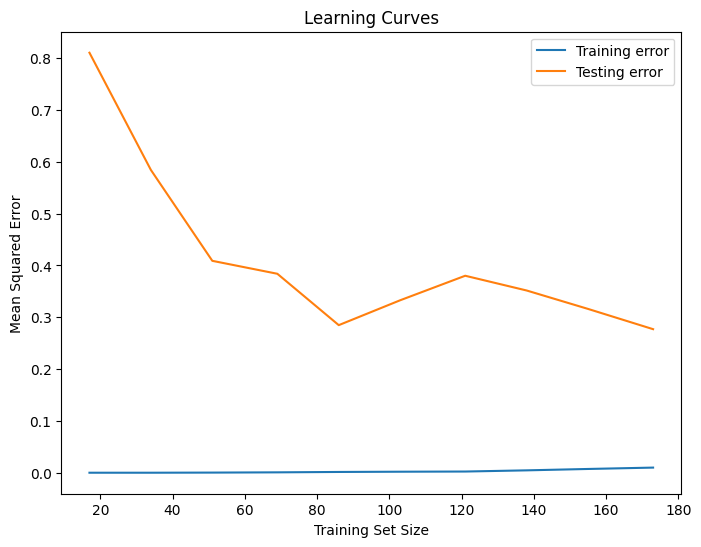

In [39]:
# compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error'
)

# transfrom into MSE
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, test_scores_mean, label='Testing error')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Training error can suggest overfitting because the model captures noise

# 5) Model Registry

In [29]:
# Retrieve model registry
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


### 5a) Model Schema

In [40]:
# Set up the Model Schema, which describes the inputs and outputs for a model
input_schema = Schema(X)
output_schema = Schema(y)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

### 5b) Save model locally

In [41]:
# Save regressor model
joblib.dump(xgb_model, MODEL_PATH + '/'+ MODEL_NAME + '.pkl')

# Save F1 report
with open(MODEL_PATH + "/f1_report.txt", 'w') as file:
    file.write(f1_report)

### 5c) Upload model to Hopsworks

In [43]:
# Define model for Hopsworks
weather_code_model = mr.python.create_model(
    name=MODEL_NAME, 
    metrics={
        'CV F1 mean': f1_mean,
        'CV F1 SD': f1_sd,
        'CV R2 mean': r2_mean,
        'CV R2 SD': r2_sd,
        'CV MSE mean': mse_mean,
        'CV MSE SD': mse_sd,
        'CV RMSE mean': rmse_mean,
        'CV RMSE SD': rmse_sd,
        'MSE training set': train_mse,
        'MSE test set': test_mse
    },
    model_schema=model_schema, # attach model schema
    input_example=X_test.sample().values, 
    description="Weather Code predictor.")

# Upload model to Hopsworks
weather_code_model.save(MODEL_PATH)

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/178324/models/weather_code_xgboost_model/1


Model(name: 'weather_code_xgboost_model', version: 1)